# Tutorial 0: ZenML Quickstart

This tutorial demonstrates the complete workflow for training a model with ZenML
and visualizing the results. You'll learn how to:

- Set up ZenML in notebook-friendly mode (auto-detects project root, uses in-memory storage)
- Run a complete training pipeline on synthetic graph data
- Load trained models and predictions from ZenML artifacts
- Generate and interpret diagnostic plots inline in the notebook

**Why ZenML?** ZenML manages the entire ML pipeline lifecycle - it tracks
experiments, caches step outputs, and ensures reproducibility. By storing
artifacts (models, data, predictions) in ZenML, we can re-run training once
and then quickly iterate on analysis and visualization without re-training.



In [1]:
import torch

from pioneerml.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)
from pioneerml.training import plot_loss_curves
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines import zenml_training_pipeline

# Initialize ZenML for notebook use
# setup_zenml_for_notebook automatically finds the project root by searching
# upward for .zen or .zenml directories, ensuring we use the root configuration.
# use_in_memory=True creates a temporary in-memory SQLite store, perfect for
# tutorials where we don't need persistent artifact storage.
zenml_client = zenml_utils.setup_zenml_for_notebook(use_in_memory=True)
print(f"ZenML initialized with stack: {zenml_client.active_stack_model.name}")



ZenML initialized with stack: default


## Run the Training Pipeline

Here we execute the complete ZenML training pipeline. The pipeline consists of
several steps:

1. **build_datamodule**: Creates synthetic graph data and splits it into train/val sets
2. **build_module**: Instantiates the GroupClassifier model wrapped in a Lightning module
3. **train_module**: Trains the model using PyTorch Lightning (auto-detects CPU/GPU)
4. **collect_predictions**: Runs inference on the validation set to get predictions and targets

**Why use `enable_cache=False`?** This ensures the pipeline runs fresh each time,
which is useful for tutorials. In production, you'd typically enable caching to
skip re-running unchanged steps.

After the pipeline completes, we load the artifacts (trained model, datamodule,
predictions, targets) using `load_step_output`. These artifacts are stored by
ZenML and can be reloaded anytime without re-running the pipeline - this makes
notebooks fast and interactive.



In [2]:
run = zenml_training_pipeline.with_options(enable_cache=False)()
print(f"Pipeline run status: {run.status}")

trained_module = load_step_output(run, "train_module")
datamodule = load_step_output(run, "build_datamodule")
predictions = load_step_output(run, "collect_predictions")[0]
targets = load_step_output(run, "collect_predictions")[1]

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the zenml_training_pipeline run.")

trained_module.eval()
datamodule.setup(stage="fit")
device = next(trained_module.parameters()).device
print(f"Loaded artifacts from run {run.name} (device={device})")



Initiating a new run for the pipeline: zenml_training_pipeline.
Caching is disabled by default for zenml_training_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  orchestrator: default
  deployer: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_datamodule has started.
Step build_datamodule has finished in 0.092s.
Step build_module has started.
Step build_module has finished in 0.078s.
Step train_module has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | GroupClassifier   | 1.1 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.522     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[train_module] /home/jack/virtual_environments/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=15 in the DataLoader` to improve performance.

[train_module] /home/jack/virtual_environments/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=15 in the DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Step train_module has finished in 0.903s.
Step collect_predictions has started.
Step collect_predictions has finished in 0.786s.
Pipeline run has finished in 2.726s.
Pipeline run status: completed
Loaded artifacts from run zenml_training_pipeline-2025_11_25-02_47_42_928908 (device=cpu)


## Verify Predictions Were Collected

The `collect_predictions` step in the pipeline has already run inference and
collected predictions and targets. This cell simply verifies how many samples
were processed. The predictions are raw logits (before sigmoid), and targets
are one-hot encoded class labels - both ready for evaluation metrics and plots.



In [3]:
print(f"Collected predictions for {len(targets)} samples via pipeline step.")

Collected predictions for 3 samples via pipeline step.


## Visualize Training Diagnostics

We generate four diagnostic plots to understand model performance. All plots are
displayed inline in the notebook (no files saved) by setting `show=True` and
`save_path=None`. This makes the notebook self-contained and easy to share.

**1. Loss Curves** - Shows training and validation loss over epochs
- **What it shows**: How well the model is learning during training
- **Good signs**: Both curves decrease steadily and stay close together
- **Warning signs**: Large gap between train/val (overfitting), or flat lines (not learning)

**2. Confusion Matrices** - Per-class classification accuracy
- **What it shows**: For each class (π, μ, e+), how many true positives, false positives,
  true negatives, and false negatives
- **Good signs**: Dark diagonal (correct predictions), light off-diagonal (few errors)
- **Why normalized**: Makes it easy to compare classes with different sample sizes

**3. ROC Curves** - Ranking quality across all possible thresholds
- **What it shows**: True Positive Rate vs False Positive Rate as we vary the
  classification threshold
- **AUC score**: Area under curve - higher is better (1.0 = perfect, 0.5 = random)
- **Good signs**: Curves in top-left corner, AUC > 0.8

**4. Precision-Recall Curves** - Performance on imbalanced data
- **What it shows**: Precision vs Recall trade-off as we vary the threshold
- **Average Precision**: Summarizes performance, especially important for imbalanced classes
- **Good signs**: High curves that maintain precision even at high recall



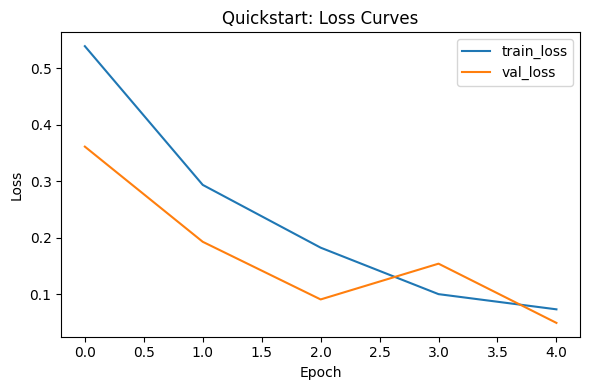

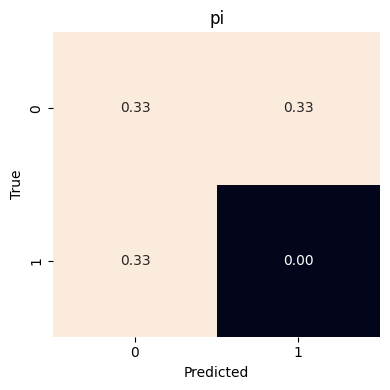

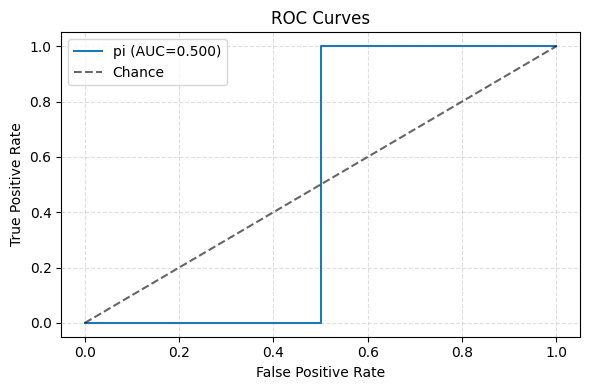

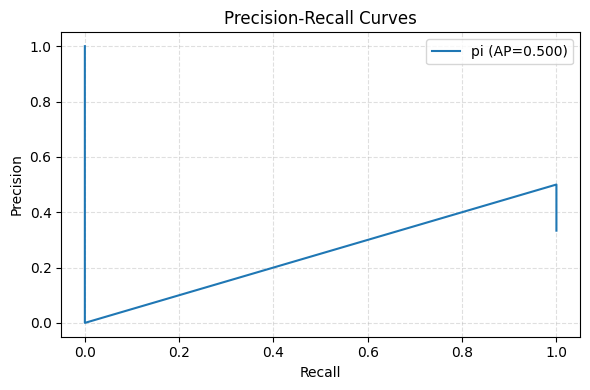

In [4]:
plot_loss_curves(trained_module, title="Quickstart: Loss Curves", show=True)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    threshold=0.5,
    normalize=True,
    save_path=None,
    show=True,
)

plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    save_path=None,
    show=True,
)

plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    save_path=None,
    show=True,
)
